In [2]:
import pandas as pd 
import numpy as np
# fmt: off
data = pd.DataFrame(dict(
    year = np.arange(1900., 1921., 1),
    lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]),
    hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])))
data.head()
# fmt: on

,year,lynx,hare
0,1900.0,4.0,30.0
1,1901.0,6.1,47.2
2,1902.0,9.8,70.2
3,1903.0,35.2,77.4
4,1904.0,59.4,36.3


In [3]:
from numba import njit

# not just in time
@njit 
# right hand side of the ODE
def rhs(X, t, theta): 
    # unpack parameters
    x, y = X
    alpha, beta, gamma, delta, xt0, yt0 = theta
    # equations
    dx_dt = alpha * x - beta * x * y
    dy_dt = -gamma * y + delta * x * y
    return [dx_dt, dy_dt]

In [4]:
# plot data function for reuse later
def plot_data(ax, lw=2, title="Hudson's Bay Company Data"):
    ax.plot(data.year, data.lynx, color="b", lw=lw, marker="o", markersize=12, label="Lynx (Data)")
    ax.plot(data.year, data.hare, color="g", lw=lw, marker="+", markersize=14, label="Hare (Data)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlim([1900, 1920])
    ax.set_ylim(0)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Pelts (Thousands)", fontsize=14)
    ax.set_xticks(data.year.astype(int))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_title(title, fontsize=16)
    return ax

In [5]:
# plot model function
def plot_model(
    ax,
    x_y,
    time=np.arange(1900, 1921, 0.01),
    alpha=1,
    lw=3,
    title="Hudson's Bay Company Data and\nExample Model Run",
):

    ax.plot(time, x_y[:, 1], color="b", alpha=alpha, lw=lw, label="Lynx (Model)")
    ax.plot(time, x_y[:, 0], color="g", alpha=alpha, lw=lw, label="Hare (Model)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    return ax

<Axes: title={'center': "Hudson's Bay Company Data and\nExample Model Run"}, xlabel='Year', ylabel='Pelts (Thousands)'>

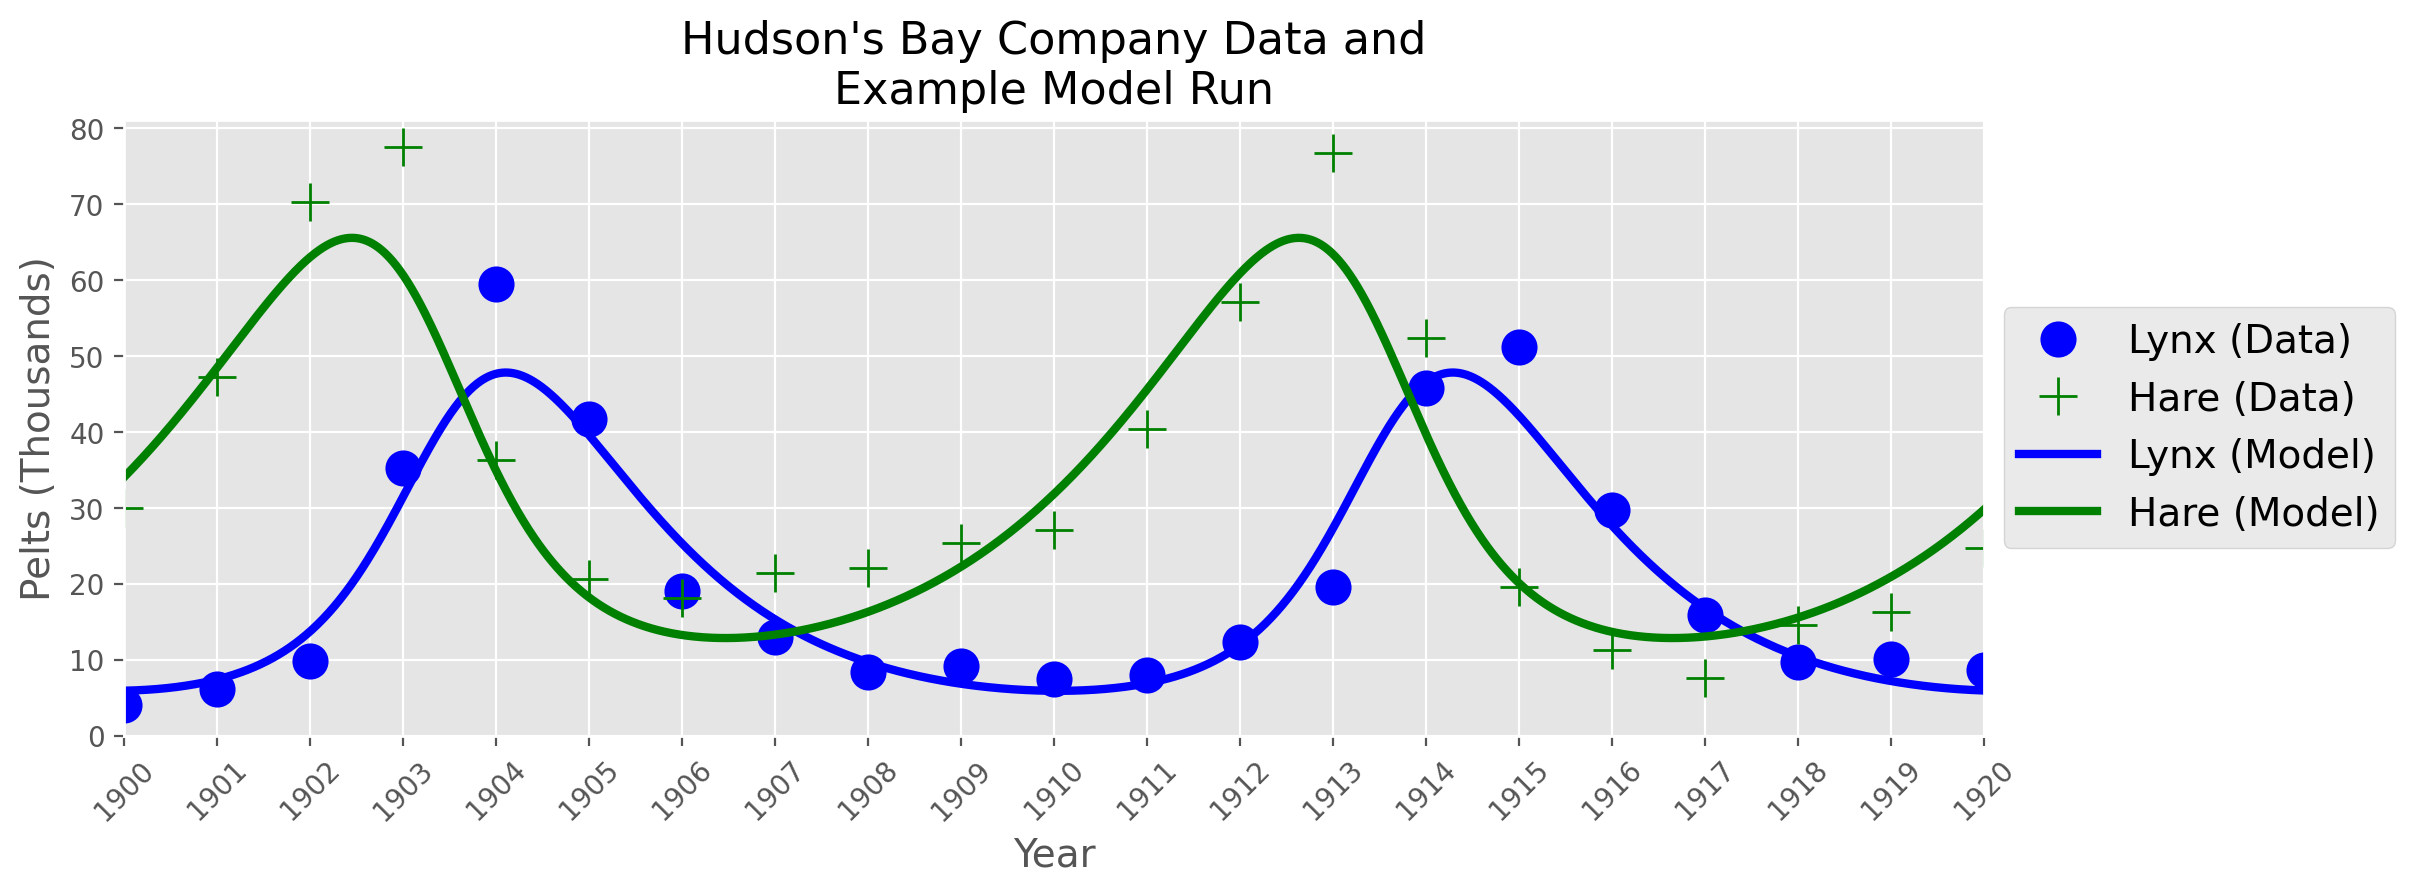

In [6]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# set theme
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

# note theta = alpha, beta, gamma, delta, xt0, yt0
theta = np.array([0.52, 0.026, 0.84, 0.026, 34.0, 5.9])
time = np.arange(1900, 1921, 0.01)

# call Scipy's odeint function
x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))

# plot
_, ax = plt.subplots(figsize=(12, 4))
plot_data(ax, lw=0)
plot_model(ax, x_y)

# Least-squares to estimate parameters

In [7]:
from scipy.optimize import least_squares

# function that calculates residuals based on a given theta
def ode_model_resid(theta):
    return (
        data[["hare", "lynx"]] - odeint(func=rhs, y0=theta[-2:], t=data.year, args=(theta,))
    ).values.flatten()

In [8]:
# calculate least squares using the Scipy solver
results = least_squares(ode_model_resid, x0=theta)

# put the results in a dataframe for presentation and convenience
df = pd.DataFrame()
parameter_names = ["alpha", "beta", "gamma", "delta", "h0", "l0"]
df["Parameter"] = parameter_names
df["Least Squares Solution"] = results.x
df.round(2)

,Parameter,Least Squares Solution
0,alpha,0.48
1,beta,0.02
2,gamma,0.93
3,delta,0.03
4,h0,34.91
5,l0,3.86


<Axes: title={'center': 'Least Squares Solution'}, xlabel='Year', ylabel='Pelts (Thousands)'>

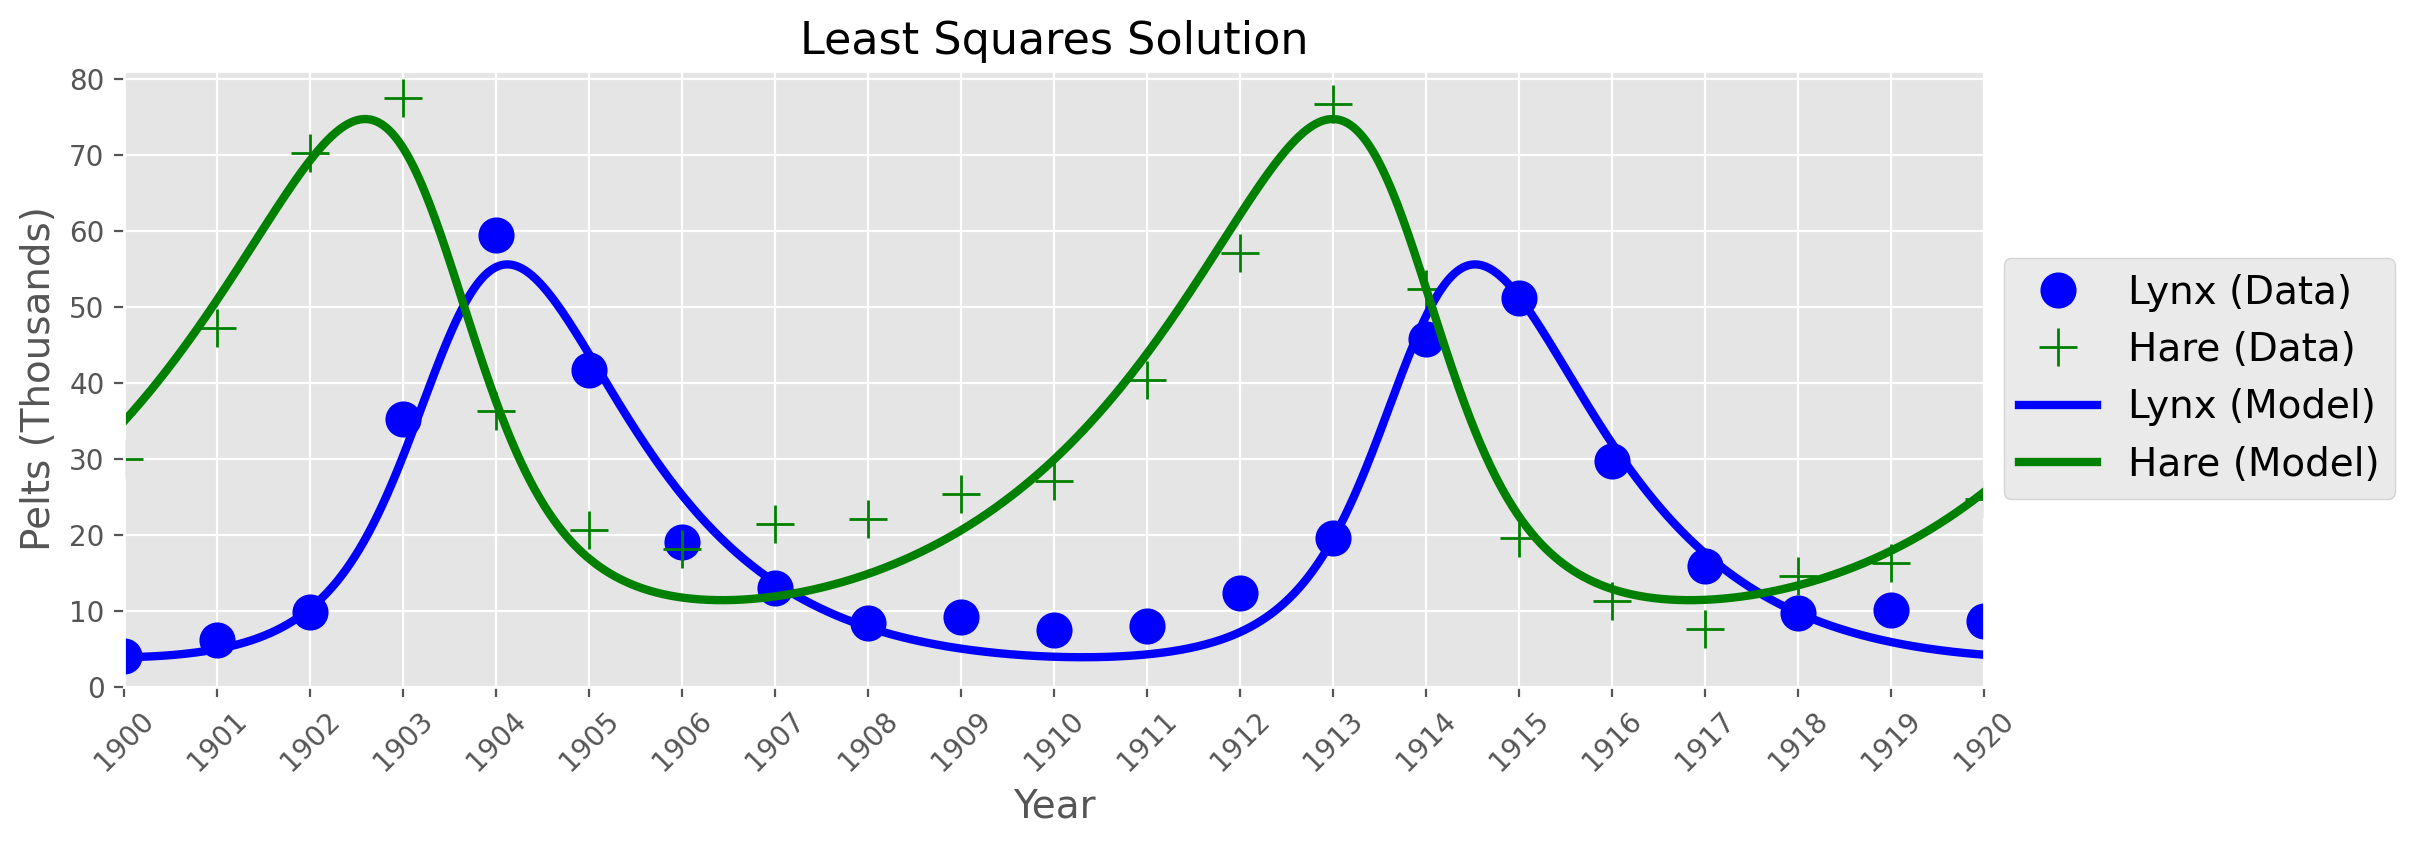

In [9]:
time = np.arange(1900, 1921, 0.01)
theta = results.x
x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))
fig, ax = plt.subplots(figsize=(12, 4))
plot_data(ax, lw=0)
plot_model(ax, x_y, title="Least Squares Solution")

# Bayesian inference on parameters

In [10]:
from pytensor.compile import as_op
import pytensor.tensor as pt

# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func=rhs, y0=theta[-2:], t=data.year, args=(theta,))

In [11]:
import pymc as pm 

theta = results.x  # least squares solution used to inform the priors
with pm.Model() as model:
    # Priors
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=0.01, lower=0, initval=theta[3])
    xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=1, lower=0, initval=theta[4])
    yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=1, lower=0, initval=theta[5])
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([alpha, beta, gamma, delta, xt0, yt0])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=data[["hare", "lynx"]].values)

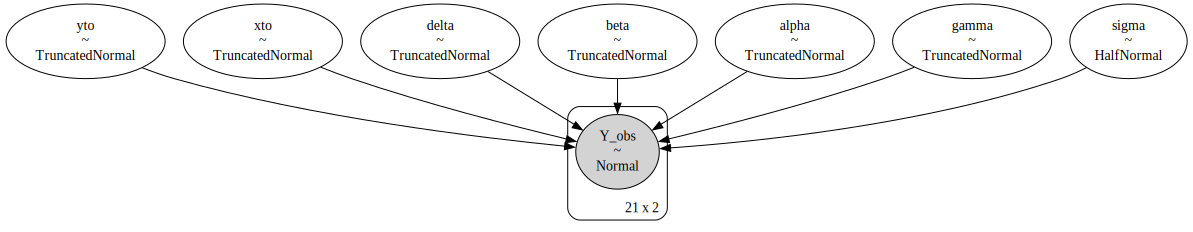

In [12]:
pm.model_to_graphviz(model=model)

In [13]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ["alpha", "beta", "gamma", "delta", "xto", "yto"]
    row = trace_df.iloc[row_idx, :][cols].values

    # alpha, beta, gamma, delta, Xt0, Yt0
    time = np.arange(1900, 1921, 0.01)
    theta = row
    x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))
    plot_model(ax, x_y, time=time, lw=lw, alpha=alpha)

In [14]:
import arviz as az
def plot_inference(
    ax,
    trace,
    num_samples=25,
    title="Hudson's Bay Company Data and\nInference Model Runs",
    plot_model_kwargs=dict(lw=1, alpha=0.2),
):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)

In [15]:
# Variable list to give to the sample step parameter
vars_list = list(model.values_to_rvs.keys())[:-1]

In [17]:
# Specify the sampler
sampler = "Slice Sampler"
tune = draws = 2000

# Inference!
with model:
    trace_slice = pm.sample(step=[pm.Slice(vars_list)], tune=tune, draws=draws, cores=1) # gradient free sampler
trace = trace_slice
az.summary(trace)


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [alpha]
>>Slice: [beta]
>>Slice: [gamma]
>>Slice: [delta]
>>Slice: [xto]
>>Slice: [yto]
>NUTS: [sigma]


KeyError: 'tune'

Text(0.5, 0.98, 'Trace Plot Slice Sampler')

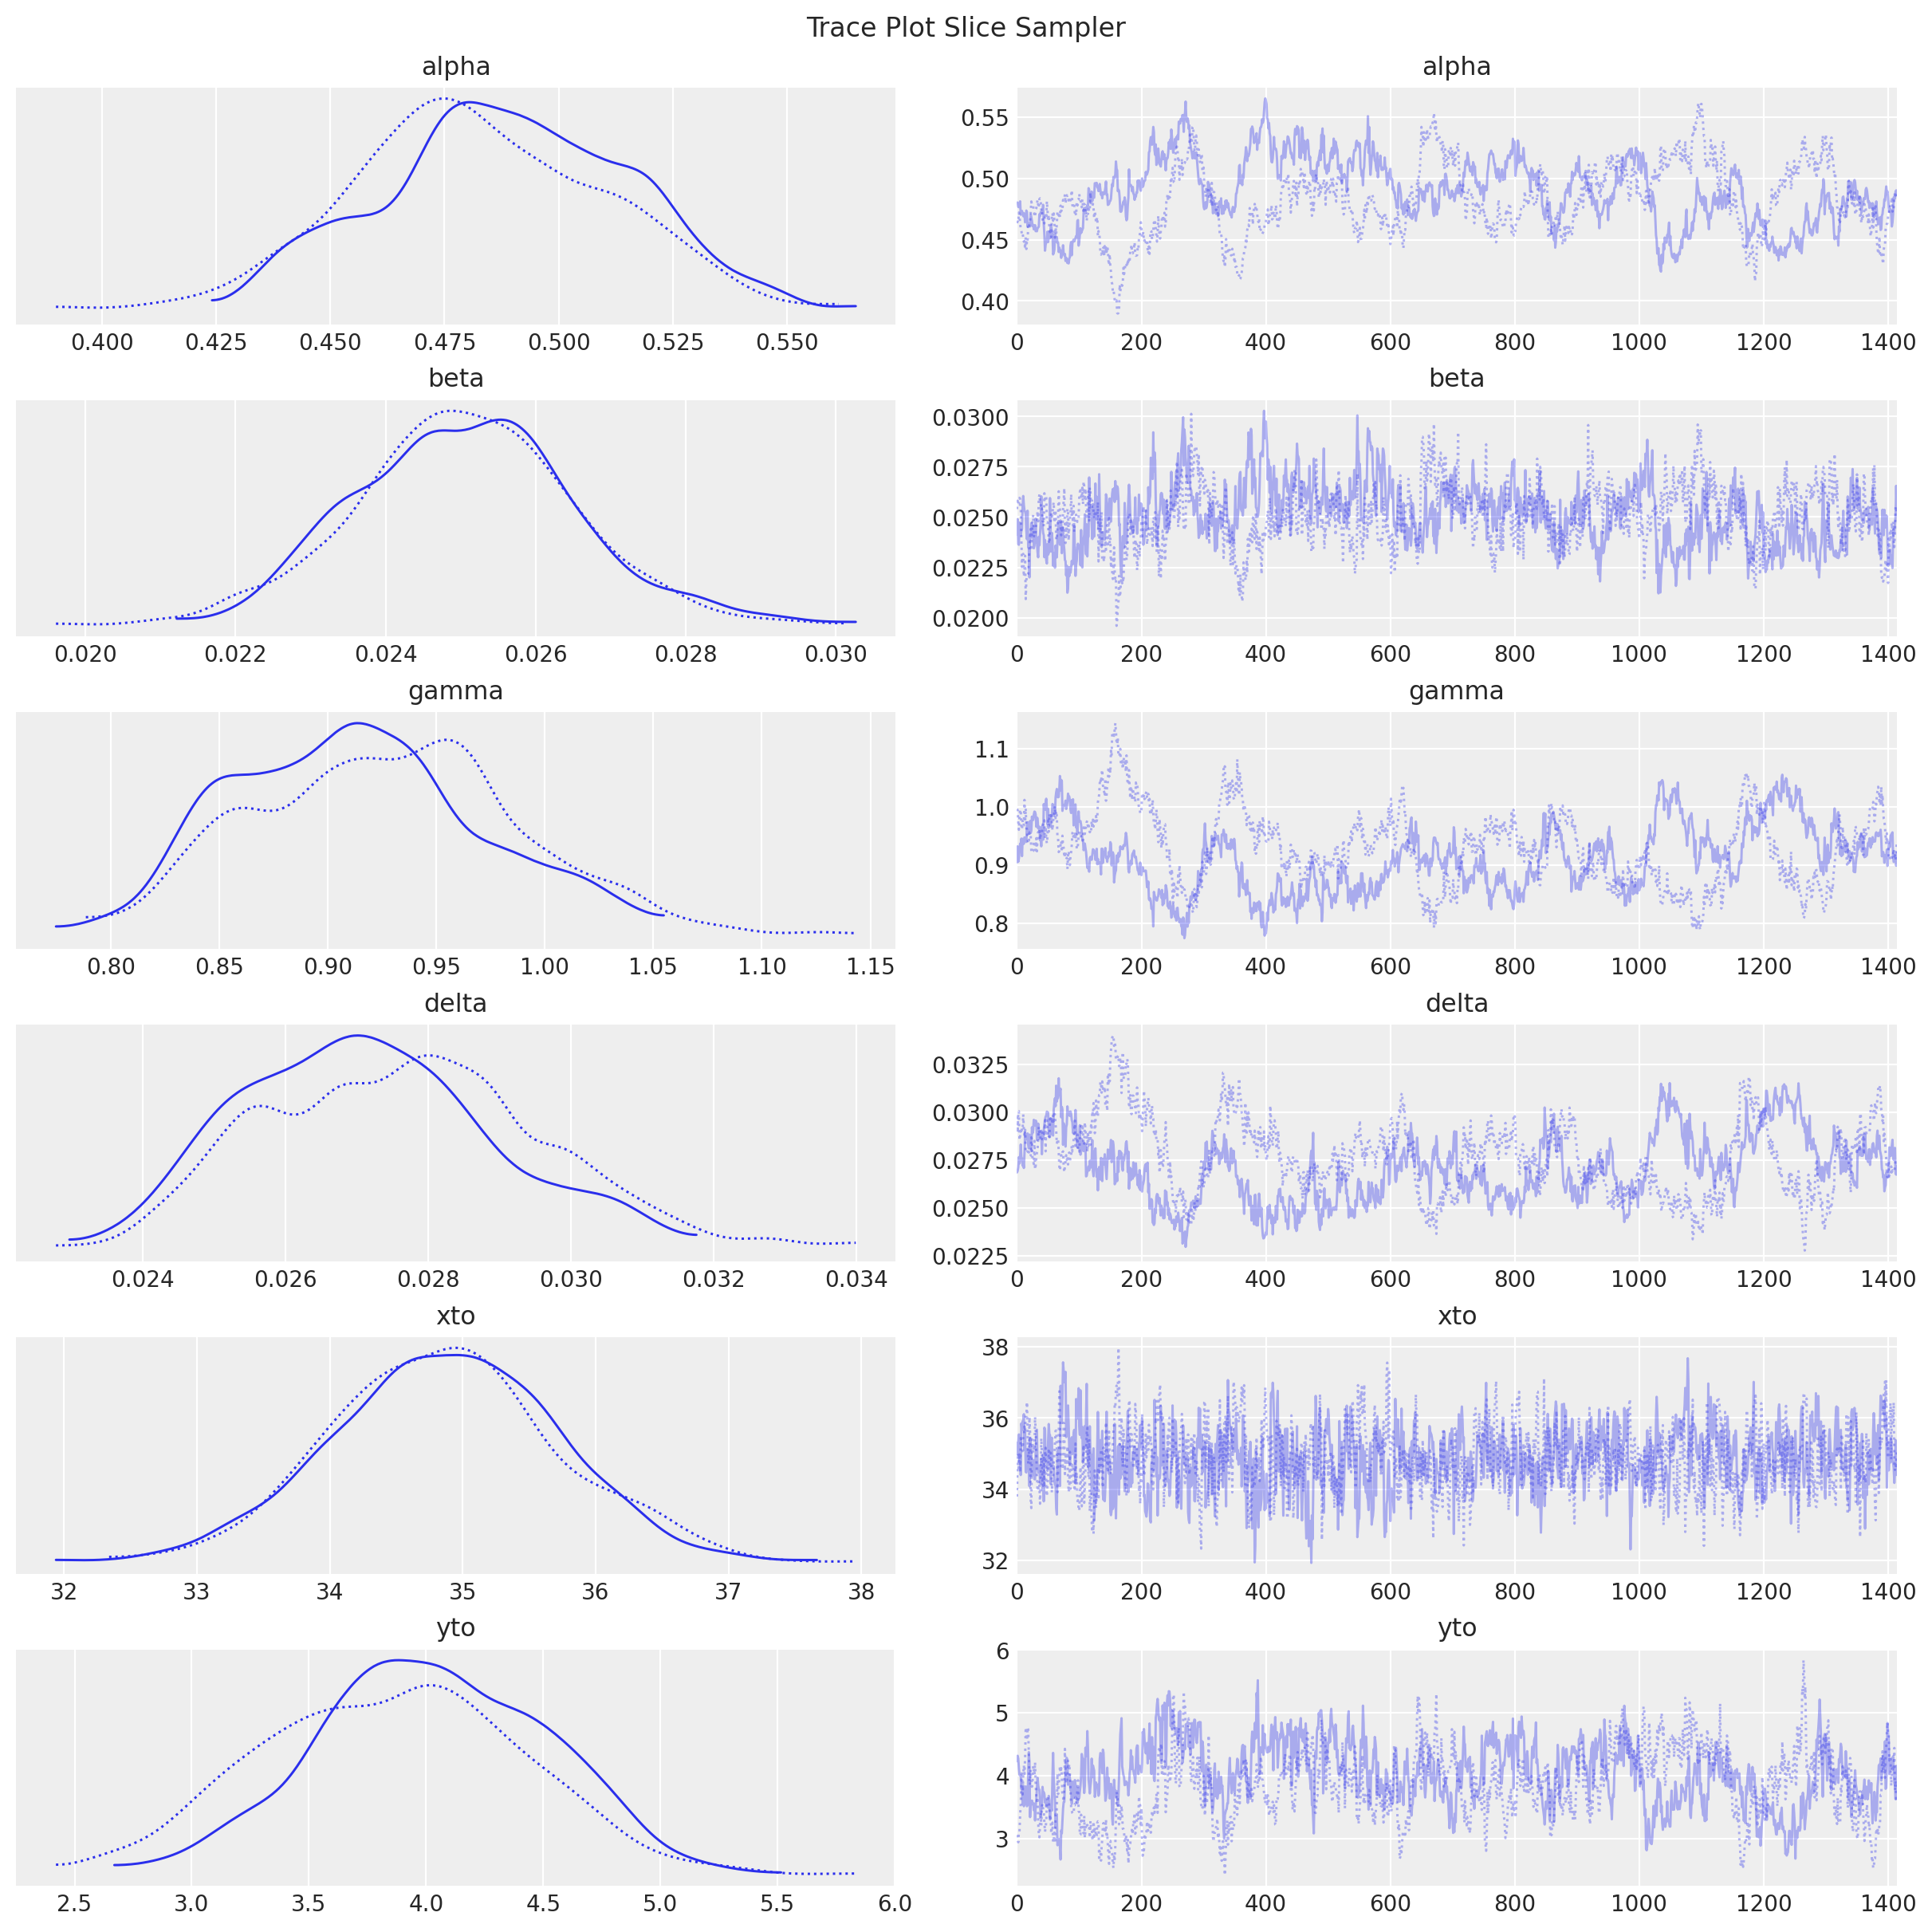

In [ ]:
az.style.use("arviz-darkgrid")
az.plot_trace(trace, var_names=["alpha", "beta", "gamma", "delta", "xto", "yto"])
plt.suptitle(f"Trace Plot {sampler}")

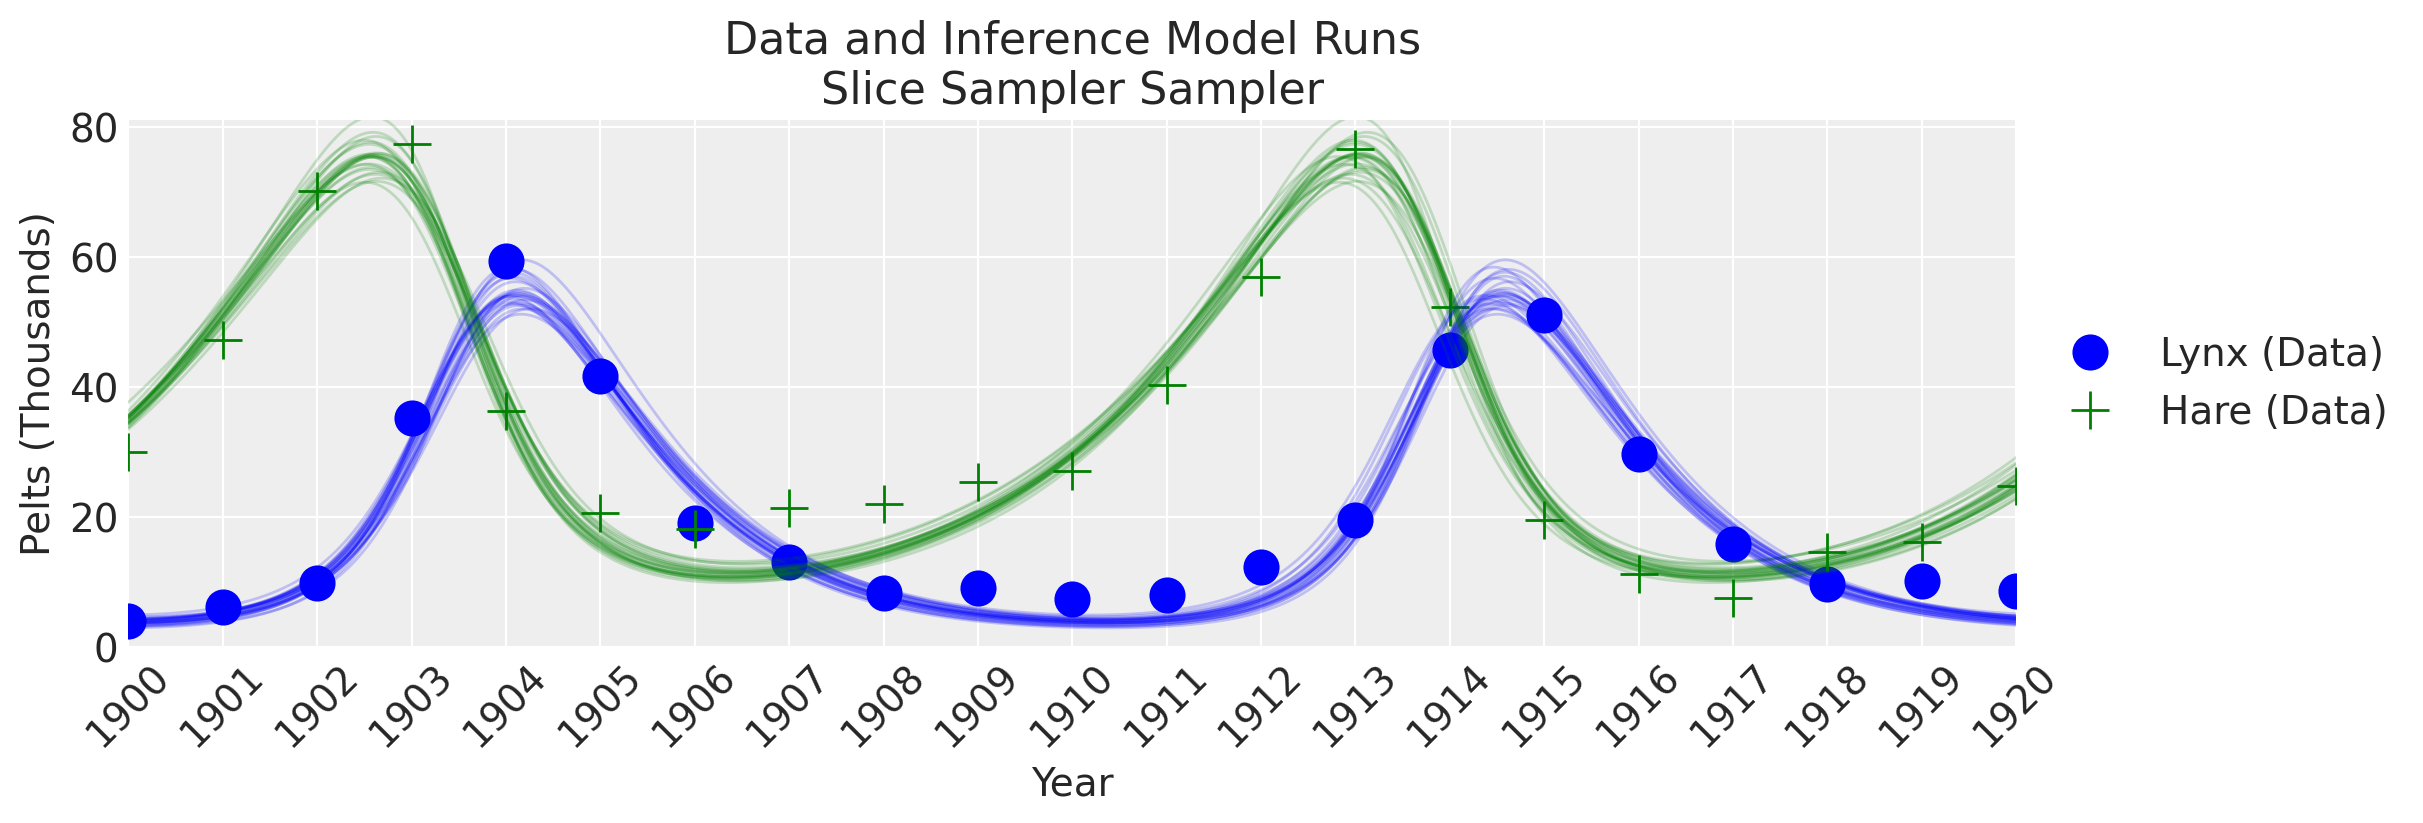

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler")